# LAB 3 PART 2: Assignment 1

Author: Aliprandi Francesco

## Echo State Network

In [1]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("data/NARMA10.csv", header=None)
X, Y =  torch.tensor(df.iloc[0]),  torch.tensor(df.iloc[1])

X.shape, Y.shape

(torch.Size([10000]), torch.Size([10000]))

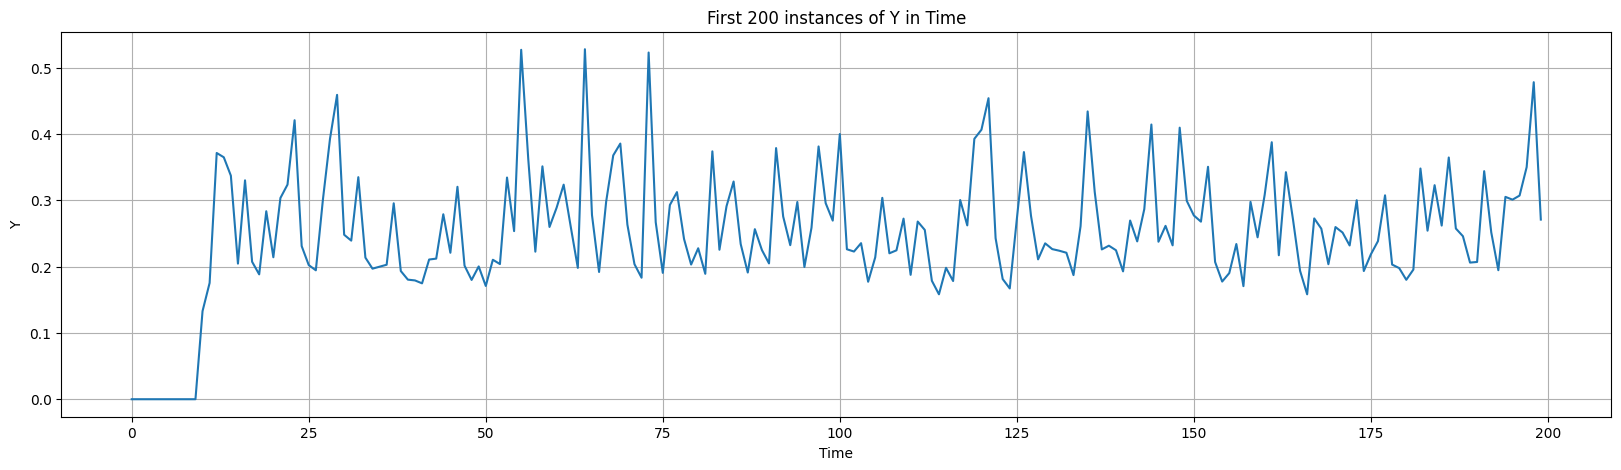

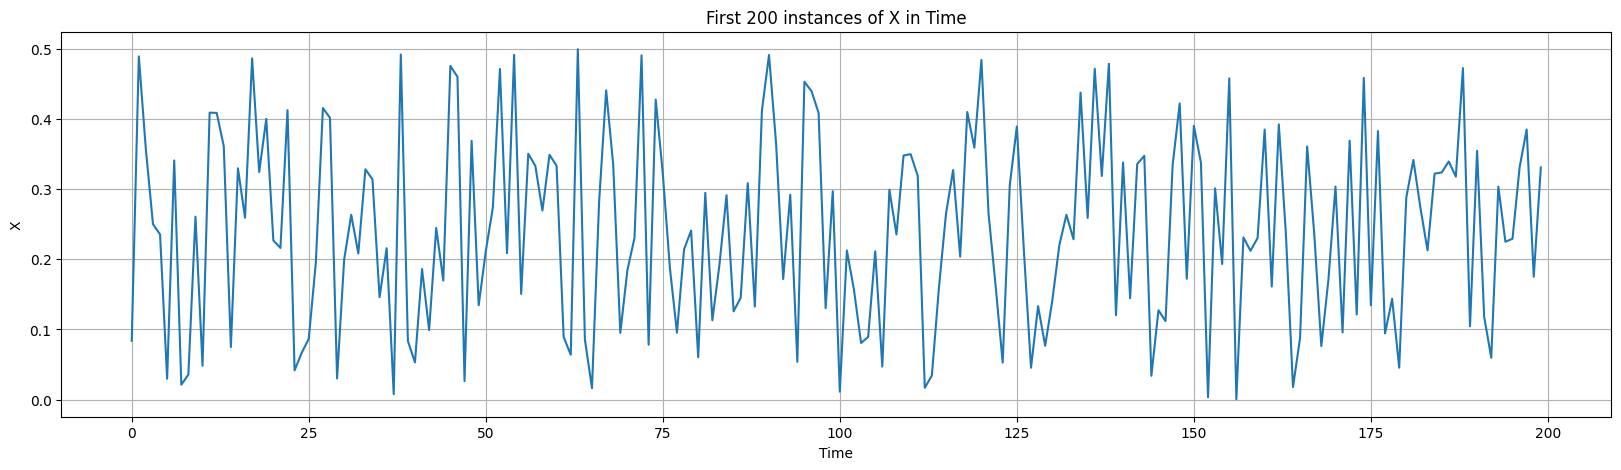

In [2]:
from utils import plot_time_series

time = torch.arange(0, X.shape[0])

plot_time_series(time, Y, "First 200 instances of Y in Time", "Time", "Y", 200)
plot_time_series(time, X, "First 200 instances of X in Time", "Time", "X", 200)
    

### Data Split

In [3]:
from utils import split_data

x_train, x_val, x_test, y_train, y_val, y_test = split_data(X, Y, train_size=4000, val_size=1000)

x_train = x_train.reshape(-1, 1).float()
x_val = x_val.reshape(-1, 1).float()
x_test = x_test.reshape(-1, 1).float()

y_train = y_train.reshape(-1, 1).float()
y_val = y_val.reshape(-1, 1).float()
y_test = y_test.reshape(-1, 1).float()
    
print(f"Training set shape: {x_train.shape}")
print(f"Validation set shape: {x_val.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: torch.Size([4000, 1])
Validation set shape: torch.Size([1000, 1])
Test set shape: torch.Size([5000, 1])


### Model Selection

In [4]:
from utils import import_parameters
from learning import parallel_grid_search

config = import_parameters("esn.yaml")

best_model, train_loss, val_loss, best_params = parallel_grid_search(
    random_iter=300,
    n_iter=5,
    config=config,
    x_train=x_train,
    y_train=y_train,
    x_val=x_val,
    y_val=y_val,
    seed=42,
)

ESN Grid Search: 100%|██████████| 300/300 [41:01<00:00,  8.21s/it] 


Best validation loss: (0.002219225000590086, 0.00042513542944488464)


In [5]:
print("Best Parameters:")
for key, value in best_params.items():
    print(f" {key}: {value}")

Best Parameters:
 hidden_dim: 2048
 lambd: 0.01
 rho: 0.99
 keep_prob: 0.7
 alpha: 0.9
 omega_in: 0.3
 omega_bias: 0.9
 scaling_type: norm
 washout: 0


In [6]:

print(f"Training MSE: \t{train_loss[0]} +/- {train_loss[1]}")
print(f"Validation MSE:\t{val_loss[0]} +/- {val_loss[1]}")

Training MSE: 	0.001573143433779478 +/- 0.0004995372837299026
Validation MSE:	0.002219225000590086 +/- 0.00042513542944488464


### Model Retraining

In [7]:
x_retrain = torch.cat((x_train, x_val), dim=0)
y_retrain = torch.cat((y_train, y_val), dim=0)

best_model.fit(
    x_train = x_train,
    y_train = y_train,
    lambd=best_params['lambd'],
)    

#### Target vs Output signal for retraining and test set

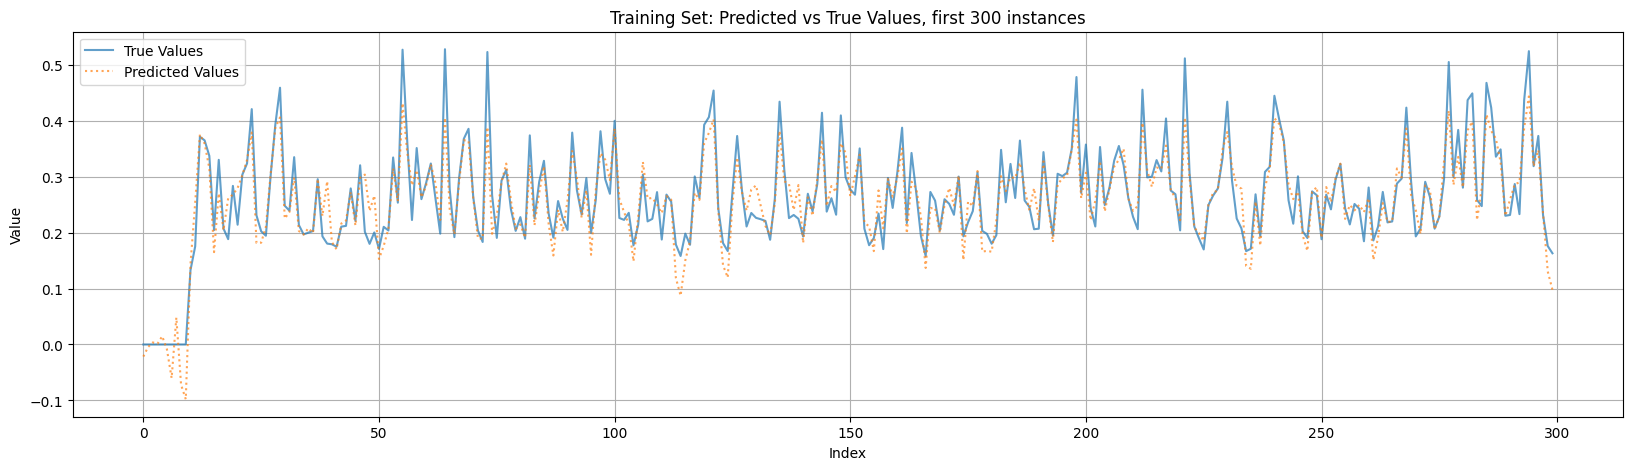

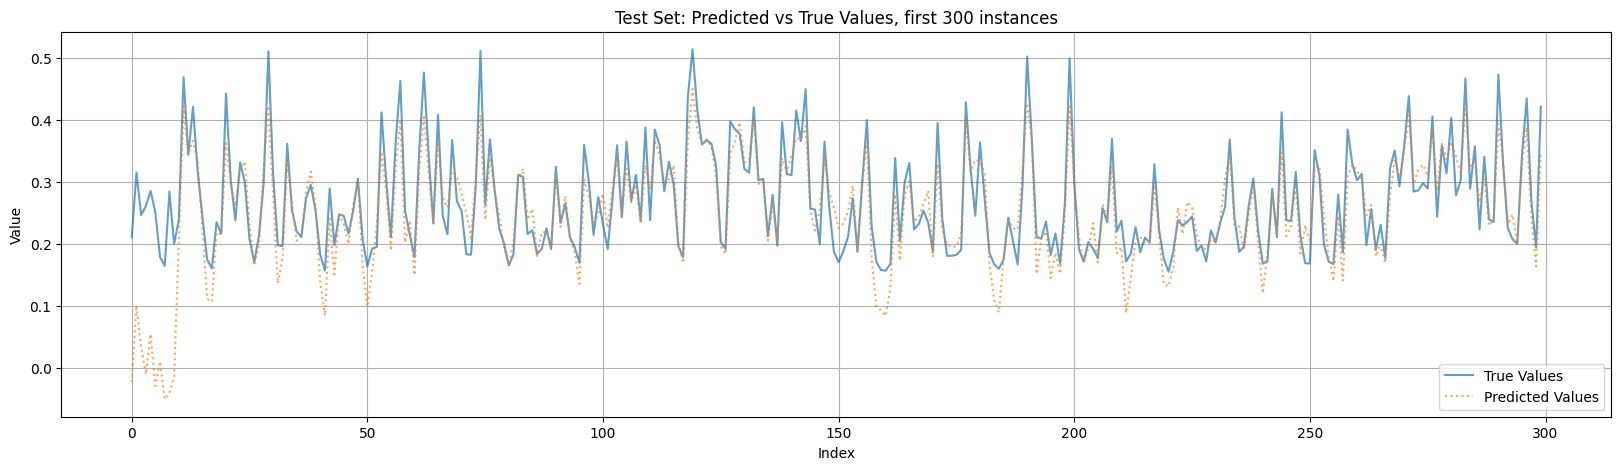

In [8]:
from utils import plot_predictions

from utils import plot_predictions

y_train_pred = best_model.forward(x_retrain)
plot_predictions(y_train, y_train_pred, "Training Set: Predicted vs True Values, first 300 instances", 300)

y_test_pred = best_model.forward(x_test)
plot_predictions(y_test, y_test_pred, "Test Set: Predicted vs True Values, first 300 instances", 300)
